# Traffic Congestion Prediction using Supervised Learning

This notebook aims to predict traffic congestion levels in Uganda using a supervised machine learning approach. The goal is to improve upon the baseline accuracy of 43% by performing thorough data cleaning, feature engineering, and model optimization.

### Plan for Improvement:
1.  **Data Cleaning and Preprocessing:** Thoroughly clean and preprocess the data to handle missing values, outliers, and inconsistencies.
2.  **Exploratory Data Analysis (EDA):** Gain insights into the data distribution, correlations, and patterns.
3.  **Feature Engineering:** Create new features from the existing data to improve model performance.
4.  **Model Building and Optimization:** Train and evaluate multiple machine learning models, including RandomForest, XGBoost, and LightGBM. Optimize the models using hyperparameter tuning.
5.  **Evaluation:** Evaluate the final model using various metrics and techniques like cross-validation and confusion matrix.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb # type: ignore
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

In [2]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


## 1. Data Loading and Initial Exploration

In [3]:
# Load the dataset
df = pd.read_csv('uganda_traffic_forecasting.csv')

# Display basic information about the dataset
print(df.shape)
display(df.head())
display(df.info())

(1538, 11)


,timestamp,location_id,vehicle_count,avg_speed,weather,day_of_week,is_holiday,event,sensor_status,road_condition,target_congestion_level
0,2023-01-01 03:00:00,ENT002,23.0,40.72036861283745,Clear,Thursday,0.0,Parade,FAIL,Good,0.0
1,2023-01-01 03:15:00,GUL004,15.0,37.87791030098848,Rainy,Tuesday,0.0,Parade,FAIL,Poor,1.0
2,2023-01-01 03:30:00,GUL004,21.0,30.480815399777644,Clear,Saturday,1.0,Marathon,OK,Moderate,2.0
3,2023-01-01 03:45:00,MBR003,25.0,40.774805185188626,Rainy,Monday,0.0,NaN,UNKNOWN,???,0.0
4,2023-01-01 04:00:00,GUL004,15.0,42.57752540142751,Snowy,Friday,0.0,Marathon,OK,Moderate,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   timestamp                1537 non-null   object
 1   location_id              1534 non-null   object
 2   vehicle_count            1536 non-null   object
 3   avg_speed                1537 non-null   object
 4   weather                  1533 non-null   object
 5   day_of_week              1533 non-null   object
 6   is_holiday               1534 non-null   object
 7   event                    1155 non-null   object
 8   sensor_status            1538 non-null   object
 9   road_condition           1536 non-null   object
 10  target_congestion_level  1537 non-null   object
dtypes: object(11)
memory usage: 132.3+ KB


None

## 2. Data Cleaning and Preprocessing

In [4]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Coerce numeric columns read as objects
for col in ['vehicle_count', 'avg_speed', 'target_congestion_level', 'is_holiday']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Standardize anomaly strings to NaN
df.replace(['???', 'None', 'none', '?', 'undefined', 'null'], np.nan, inplace=True)

# Parse timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Impute missing values
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

for c in num_cols:
    df[c].fillna(df[c].median(), inplace=True)
for c in cat_cols:
    df[c].fillna(df[c].mode()[0], inplace=True)

df['timestamp'].fillna(method='ffill', inplace=True)

# Final check for missing values
print("Missing values per column:", df.isna().sum())

Missing values per column: timestamp                  0
location_id                0
vehicle_count              0
avg_speed                  0
weather                    0
day_of_week                0
is_holiday                 0
event                      0
sensor_status              0
road_condition             0
target_congestion_level    0
dtype: int64


C:\Users\HP ELITEBOOK 840 G5\AppData\Local\Temp\ipykernel_20176\1837397441.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)
C:\Users\HP ELITEBOOK 840 G5\AppData\Local\Temp\ipykernel_20176\1837397441.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

## 3. Feature Engineering

We will create a rich set of features to help the model learn the underlying patterns in the data.

In [5]:
df_feat = df.copy()

# Time-based features
df_feat['hour'] = df_feat['timestamp'].dt.hour
df_feat['weekday'] = df_feat['timestamp'].dt.weekday
df_feat['is_weekend'] = df_feat['weekday'].isin([5, 6]).astype(int)
df_feat['month'] = df_feat['timestamp'].dt.month
df_feat['day_of_year'] = df_feat['timestamp'].dt.dayofyear
df_feat['week_of_year'] = df_feat['timestamp'].dt.isocalendar().week.astype(int)

# Cyclical encoding for hour and month
df_feat['hour_sin'] = np.sin(2 * np.pi * df_feat['hour'] / 24)
df_feat['hour_cos'] = np.cos(2 * np.pi * df_feat['hour'] / 24)
df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month'] / 12)
df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month'] / 12)

# Traffic dynamics
df_feat['speed_per_vehicle'] = df_feat['avg_speed'] / (df_feat['vehicle_count'] + 1)
df_feat['veh_density'] = df_feat['vehicle_count'] / (df_feat['hour'] + 1)

# Lag features
df_feat = df_feat.sort_values('timestamp')
df_feat['vehicle_count_lag1'] = df_feat['vehicle_count'].shift(1)
df_feat['avg_speed_lag1'] = df_feat['avg_speed'].shift(1)

# Rolling mean features
df_feat['vehicle_count_roll3'] = df_feat['vehicle_count'].rolling(window=3, min_periods=1).mean()
df_feat['avg_speed_roll3'] = df_feat['avg_speed'].rolling(window=3, min_periods=1).mean()

# Interaction features
df_feat['weather_road'] = df_feat['weather'] + '_' + df_feat['road_condition']

# Create the target variable
df_feat['congestion_class'] = pd.cut(
    df_feat['target_congestion_level'],
    bins=[-1, 1.5, 3.5, 5],
    labels=[0, 1, 2]  # 0: Low, 1: Medium, 2: High
).astype(int)

# Drop rows with NA from lag/rolling features
df_feat = df_feat.dropna().reset_index(drop=True)

display(df_feat.head())

,timestamp,location_id,vehicle_count,avg_speed,weather,day_of_week,is_holiday,event,sensor_status,road_condition,...,month_sin,month_cos,speed_per_vehicle,veh_density,vehicle_count_lag1,avg_speed_lag1,vehicle_count_roll3,avg_speed_roll3,weather_road,congestion_class
0,2023-01-01 03:15:00,GUL004,15.0,37.877910,Rainy,Tuesday,0.0,Parade,FAIL,Poor,...,0.5,0.866025,2.367369,3.75,23.0,40.720369,19.000000,39.299139,Rainy_Poor,0
1,2023-01-01 03:30:00,GUL004,21.0,30.480815,Clear,Saturday,1.0,Marathon,OK,Moderate,...,0.5,0.866025,1.385492,5.25,15.0,37.877910,19.666667,36.359698,Clear_Moderate,1
2,2023-01-01 03:45:00,MBR003,25.0,40.774805,Rainy,Monday,0.0,Accident,UNKNOWN,Good,...,0.5,0.866025,1.568262,6.25,21.0,30.480815,20.333333,36.377844,Rainy_Good,0
3,2023-01-01 04:00:00,GUL004,15.0,42.577525,Snowy,Friday,0.0,Marathon,OK,Moderate,...,0.5,0.866025,2.661095,3.00,25.0,40.774805,20.333333,37.944382,Snowy_Moderate,0
4,2023-01-01 04:30:00,ENT002,19.0,43.341764,Foggy,Wednesday,0.0,Accident,UNKNOWN,Good,...,0.5,0.866025,2.167088,3.80,15.0,42.577525,19.666667,42.231365,Foggy_Good,1


## 4. Model Building and Optimization

In [6]:
# Feature Selection
features = [
    'vehicle_count', 'avg_speed', 'is_holiday', 'is_weekend',
    'hour', 'weekday', 'veh_density', 'speed_per_vehicle', 'weather_road', 'location_id',
    'vehicle_count_lag1', 'avg_speed_lag1', 'vehicle_count_roll3', 'avg_speed_roll3',
    'day_of_year', 'week_of_year', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos'
]

df_model = pd.get_dummies(df_feat[features + ['congestion_class']], columns=['weather_road', 'location_id'], drop_first=True)
X = df_model.drop('congestion_class', axis=1)
y = df_model['congestion_class']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 4.1. RandomForest Classifier with Hyperparameter Tuning

In [7]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 12, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
best_rf = grid_search.best_estimator_

y_pred_rf = best_rf.predict(X_test)
print('RandomForest Accuracy:', accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForest Accuracy: 0.48464163822525597
              precision    recall  f1-score   support

           0       0.50      0.67      0.57       125
           1       0.48      0.46      0.47       112
           2       0.38      0.11      0.17        56

    accuracy                           0.48       293
   macro avg       0.45      0.41      0.40       293
weighted avg       0.47      0.48      0.46       293



### 4.2. LightGBM Classifier

In [8]:
lgb_clf = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
lgb_clf.fit(X_train, y_train)

y_pred_lgb = lgb_clf.predict(X_test)
print('LightGBM Accuracy:', accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

c:\Users\HP ELITEBOOK 840 G5\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\HP ELITEBOOK 840 G5\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\HP ELITEBOOK 840 G5\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP ELITEBOOK 840 G5\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\HP ELITEBOOK 840 G5\anaconda3\Lib\subprocess.py",

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 1172, number of used features: 30
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM Accuracy: 0.43686006825938567
              precision    recall  f1-score   support

           0       0.49      0.52      0.50       125
           1       0.47      0.49      0.48       112
           2       0.19      0.14      0.16        56

    accuracy                           0.44       293
   macro avg       0.38      0.38      0.38       293
weighted avg       0.42      0.44      0.43       293



In [9]:
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
print('XGBoost Accuracy:', accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

c:\Users\HP ELITEBOOK 840 G5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:07:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.447098976109215
              precision    recall  f1-score   support

           0       0.48      0.61      0.54       125
           1       0.46      0.43      0.44       112
           2       0.23      0.12      0.16        56

    accuracy                           0.45       293
   macro avg       0.39      0.39      0.38       293
weighted avg       0.42      0.45      0.43       293



## 5. Evaluation

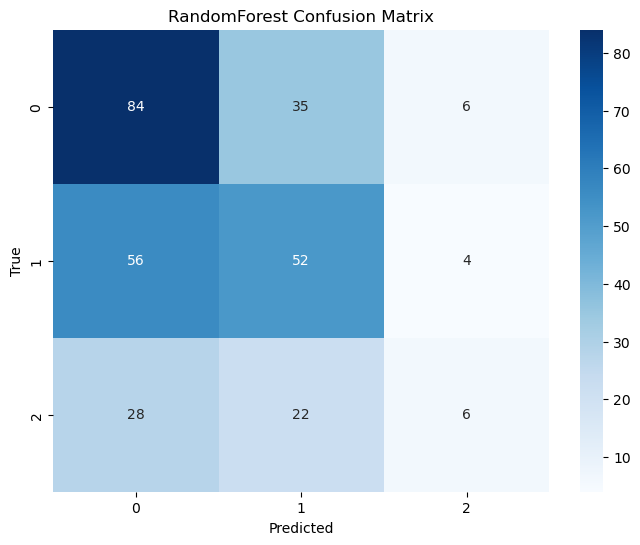

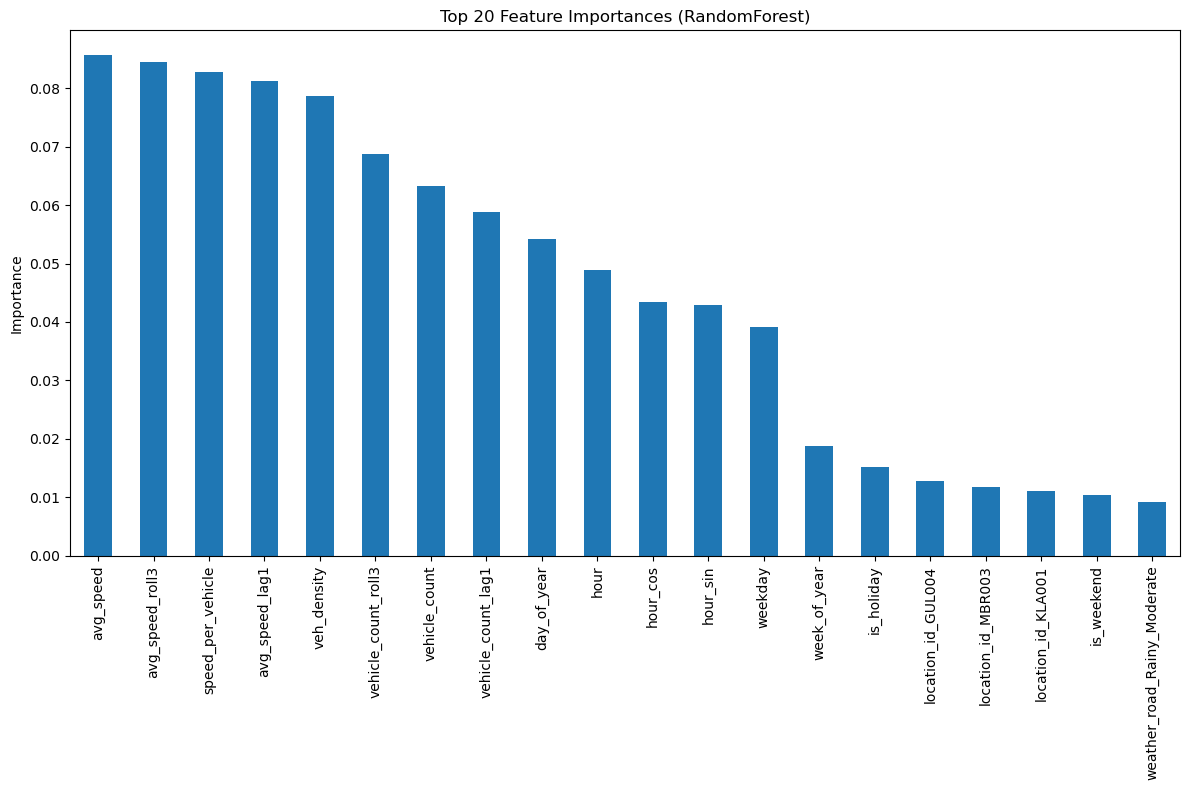

In [10]:
# Confusion Matrix for the best model (RandomForest)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RandomForest Confusion Matrix')
plt.show()

# Feature Importance from RandomForest
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
importances.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances (RandomForest)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()